# Problem 4: Speech embeddings [3.5p]

Speech is a signal with structure at multiple levels. At the lowest level, it's a high-frequency time series of air-pressure variations. But we use speech to communicate language, therefore underlying this high-frequency continuous data, there is low-frequency discrete linguistic structure. This underlying discrete sequences are usually what we are interested in for speech applications. For instance, in speech recognition we aim to extract the words that were spoken (with words being sequences of discrete symbols like phonemes, letters, or subwords).

We have seen that self-supervised learning excels at extracting meaningful high-level structured (in the sense of nicely clustered embeddings) information from high-dimensional unstructured inputs. In text, it captures the meaning of words, sentences, and so on, up to the scale of large complex documents. In images, it learns to locate and categorize objects. When applied to speech, self-supervised trained models can learn to extract the underlying linguistic information.

In this problem we will use [HuBERT](https://arxiv.org/abs/2106.07447) to extract speech representations. HuBERT is an adaptation of the BERT algorithm for text that you used in Problem 2, and which we discussed in the lecture (Slide 23), to speech. Here an illustration of the HuBERT algorithm:

![image.png](https://drive.google.com/uc?id=1GjzUc3uQpgVLvCJMuhHvNC8W2Oc8i7a0)
*Taken from the [HuBERT paper](https://arxiv.org/abs/2106.07447)*

It consists roughly of 4 steps:

1. Extract a (downsampled) sequence of frame representations ($x$ in the figure) by applying a CNN to the raw speech.
2. Produce pseudo-labels for each frame in the sequence by clustering the MFCC features (a frequency decomposition of the speech frame) using a K-Means algorithm. The cluster ids are the pseudo-labels ($z$ in the figure).
3. Mask segments of the sequence of frames with a special `[MSK]` token, and pass the masked sequence through a transformer.
4. Use the output of the transformer to predict the pseudo-labels of the masked frames.

After training, the representations obtained from the transformer blocks roughly encode the linguistic content (i.e. the underlying "text") of the speech signal. This means for instance that we expect to see clusters corresponding to phoneme classes in the embedding space.

## Self-supervised trained models as tokenizers

Recall from our previous lab that we defined character/subword/word tokenization as the assignment of integer numbers to characters/subwords/words. After tokenization, we were able to apply a language model (GPT) in order to generate text.

The fact that self-supervised trained models learn to extract representations that are amenable to clusterization (e.g. we obtain clusters in embedding space that correspond to object categories in images, or phonemes in speech) allows us to use them as tokenizers. We simply need to apply a clustering algorithm to the embeddings, and use the cluster ids as tokens. Afterwards, we can use a language model like GPT to learn a generative model!

### Tasks

In this problem, you will extract speech representations using a pre-trained HuBERT model, clusterize them to obtain speech tokens using a pre-trained K-Means model, train a small GPT model to learn to generate speech tokens, and transform back the generated speech tokens to audio, so that you get to listen to your talking GPT!

It's worth to mention that [a very similar tokenization approach can be applied to images](https://arxiv.org/pdf/2310.05737.pdf). This is a very active research area and it is used in models like ChatGPT to extend its abilities beyond text by allowing them to see (receive images as input tokens) and hear (receive speech as input tokens).

1. **(1 pt)** Implement the forward pass of the `SpeechTokenizer` and tokenize the speech data in the folder `ls1h`. In the forward pass you simply have to assign return the id of the nearest cluster for each speech representation.
2. **(1 pt)** We would like to validate that the speech tokens that our model has discovered roughly correspond to the linguistic content of the speech signal. In this task you will compare the co-occurence of speech tokens learned by our model and phones (sort of like letters, but for speech). The file `ls1h/phones.txt` contains phone labels for each speech frame (i.e. each representation extracted by HuBERT). Find a way to visualize $p(\text{phone}|\text{speech token})$, i.e. the co-occurence of phones and learned speech tokens. I leave an example of a co-occurence heatmap, but you can come up with other ways of visualizing it. Analyze what you observe.
3. **(1 pt)** Use your tokenized speech data to train a language model (you can use your GPT implementation from the previous lab or whichever model you prefer).

    Normally we would train these models on hundreds or thousands of hours of audio, but this would take too long, so we are using just 1 hour of speech. Since our data is very little, we will likely be overfitting to it, so don't bother using a validation split. We will validate the results of our model by listening to it.
    
    **_Note_**: As a preprocessing step, and in order to shorten the sequences and remove redundant information, collapse adjacent repetitions of tokens in your dataset before training the language model. E.g. if after encoding a speech sample the sequence of tokens is `[42, 42, 33, 1, 13, 11, 33, 33]`, you should remove contiguous repetitions so that it becomes `[42, 33, 1, 13, 11, 33]`. You can use `torch.unique_consecutive` for this. [This has been show to improve results](https://arxiv.org/abs/2102.01192) by removing the need of modeling the duration of the tokens, allowing the model to focus on the content.
4. **(0.5 pt)** Generate speech tokens using your trained GPT model and convert them back to audio using the `token2speech` pre-trained model. You can use `IPython.display.Audio` to listen to the generated audio in your notebook. I attach to this file a sample of what you can expect of a trained model with the default hyperparameters.

First we download the required packages. We will use [fairseq](https://github.com/facebookresearch/fairseq) from Meta which implements the HuBERT model. **You only need to do this when you start on a fresh environment. After a restart of the kernel is not needed**.

In [ ]:
# This might take a few minutes
!git clone https://github.com/facebookresearch/fairseq
!cd fairseq && pip install ./

Cloning into 'fairseq'...

remote: Enumerating objects: 35073, done.

remote: Counting objects: 100% (12/12), done.

remote: Compressing objects: 100% (12/12), done.

remote: Total 35073 (delta 0), reused 3 (delta 0), pack-reused 35061

Receiving objects: 100% (35073/35073), 25.12 MiB | 11.01 MiB/s, done.

Resolving deltas: 100% (25481/25481), done.

Processing /content/fairseq

  Installing build dependencies ... done

  Getting requirements to build wheel ... done

  Preparing metadata (pyproject.toml) ... done





     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.8/123.8 kB 4.3 MB/s eta 0:00:00







     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.3/106.3 kB 8.1 MB/s eta 0:00:00





     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 288.3/288.3 kB 12.8 MB/s eta 0:00:00






     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.4/112.4 kB 11.9 MB/s eta 0:00:00

  Preparing metadata (setup.py) ... done























  Created wheel for fairseq: filename=fairseq-0.12.2-cp310-cp31

We download the pretrained models

In [ ]:
!wget https://dl.fbaipublicfiles.com/textless_nlp/twist/speech_tokenizer/mhubert_base_25hz_cp_mls_cv_sp_fisher.pt
!wget https://dl.fbaipublicfiles.com/textless_nlp/twist/speech_tokenizer/mhubert_base_25hz_cp_mls_cv_sp_fisher_L11_km500.bin

--2024-01-27 22:15:39--  https://dl.fbaipublicfiles.com/textless_nlp/twist/speech_tokenizer/mhubert_base_25hz_cp_mls_cv_sp_fisher.pt

Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 3.163.189.14, 3.163.189.108, 3.163.189.96, ...

Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|3.163.189.14|:443... connected.

HTTP request sent, awaiting response... 200 OK

Length: 1149811398 (1.1G) [binary/octet-stream]

Saving to: ‘mhubert_base_25hz_cp_mls_cv_sp_fisher.pt’



mhubert_base_25hz_c 100%[===================>]   1.07G  98.0MB/s    in 11s     



2024-01-27 22:15:49 (103 MB/s) - ‘mhubert_base_25hz_cp_mls_cv_sp_fisher.pt’ saved [1149811398/1149811398]



--2024-01-27 22:15:49--  https://dl.fbaipublicfiles.com/textless_nlp/twist/speech_tokenizer/mhubert_base_25hz_cp_mls_cv_sp_fisher_L11_km500.bin

Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 3.163.189.14, 3.163.189.108, 3.163.189.96, ...

Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|

We will also use the [textless](https://github.com/facebookresearch/textlesslib/) library that implements the model that will transform our speech tokens back to audio.

_**IMPORTANT:** it will give you some warnings abour unmet dependencies, but you can ignore them. If when importing_ `textless` _below you get a `ModuleNotFoundError`, just restart the session after having installed the library. Afterwards the import should work.

In [ ]:
!git clone https://github.com/facebookresearch/textlesslib
!cd textlesslib && pip install -e . --no-deps
!pip install unidecode

fatal: destination path 'textlesslib' already exists and is not an empty directory.

Obtaining file:///content/textlesslib

  Preparing metadata (setup.py) ... done


  Attempting uninstall: textless

    Found existing installation: textless 0.1.0

    Uninstalling textless-0.1.0:

      Successfully uninstalled textless-0.1.0

  Running setup.py develop for textless




We download the speech data

In [ ]:
!pip install gdown==v4.6.3

![ -e  ls1h.zip ] || gdown 'https://drive.google.com/uc?id=1lCtD7xJNECUSQr14janqNcxS39pssqPn' -O ls1h.zip
![ -d ls1h ] || unzip ls1h.zip















  Attempting uninstall: gdown

    Found existing installation: gdown 4.7.3

    Uninstalling gdown-4.7.3:

      Successfully uninstalled gdown-4.7.3


Downloading...

From: https://drive.google.com/uc?id=1lCtD7xJNECUSQr14janqNcxS39pssqPn

To: /content/ls1h.zip

100% 92.7M/92.7M [00:01<00:00, 55.7MB/s]

Archive:  ls1h.zip

   creating: ls1h/

  inflating: ls1h/1088-129236-0012.wav  

  inflating: ls1h/1088-129236-0027.wav  

  inflating: ls1h/1088-129236-0024.wav  

  inflating: ls1h/1088-129236-0021.wav  

  inflating: ls1h/1088-129236-0020.wav  

  inflating: ls1h/1088-129236-0004.wav  

  inflating: ls1h/1088-129236-0001.wav  

  inflating: ls1h/1088-129236-0013.wav  

  inflating: ls1h/1088-129236-0015.wav  

  inflating: ls1h/1088-129236-0014.wav  

  inflating: ls1h/1088-129236-0003.wav  

  inflating: ls1h/1088-129236-0026.wav  

  inflating: ls1h/1088-129236-0025.wav  

  inflating: ls1h/1088-129236-0017.wav  

  inflating: ls1h/1088-129236-0002.wav  

  inflatin

We import the necessary modules for this problem

In [ ]:
import fairseq
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchaudio
import joblib
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from textless.vocoders.hifigan.vocoder import CodeHiFiGANVocoder
import IPython
device = "cuda"

## Problem 4, Task 1: Implement the forward pass of the speech tokenizer and tokenize the speech data

In [ ]:
class SpeechTokenizer(nn.Module):
    def __init__(self, feat_extractor_path, layer, km_path):
        super().__init__()
        # Loading HuBERT model
        (
            model,
            cfg,
            task,
        ) = fairseq.checkpoint_utils.load_model_ensemble_and_task([feat_extractor_path])
        self.model = model[0] # HuBERT model
        self.task = task
        self.layer = layer # Layer from which we will extract features
        # Loading trained K-Means vector quantizer
        km_model = joblib.load(km_path)
        self.C = torch.from_numpy(km_model.cluster_centers_.transpose())  # Centroids of the K-Means Clusters

    def wav2code(self, wav): # takes as input the speech waveform
        with torch.no_grad():
            if self.task.cfg.normalize:
                wav = F.layer_norm(wav, wav.shape)
            wav = wav.view(1, -1)
            feat, _ = self.model.extract_features(
                source=wav,
                padding_mask=None,
                mask=False,
                output_layer=self.layer,
            )
        # speech embeddings of dimensions sequence length x 768 (HuBERT embedding dim)
        # note that the sequence length is shorter than the waveform length, because the CNN encoder in HuBERT
        # downsamples the waveform
        feat = feat.squeeze(0)
        codes = torch.argmin(torch.cdist(feat.to(self.C.device), self.C.transpose(0, 1)), dim=1) # Cluster ids for each embedding #TODO
        return codes

speech_tokenizer = SpeechTokenizer("mhubert_base_25hz_cp_mls_cv_sp_fisher.pt", # Name of the HuBERT model you downloaded
                                   11, # The K-Means model that we use was trained on embeddings from layer 11 of HuBERT
                                   "mhubert_base_25hz_cp_mls_cv_sp_fisher_L11_km500.bin") # Name of the K-Means model you downloaded
speech_tokenizer.to(device)

SpeechTokenizer(
  (model): HubertModel(
    (feature_extractor): ConvFeatureExtractionModel(
      (conv_layers): ModuleList(
        (0): Sequential(
          (0): Conv1d(1, 512, kernel_size=(10,), stride=(5,), bias=False)
          (1): Dropout(p=0.0, inplace=False)
          (2): Fp32GroupNorm(512, 512, eps=1e-05, affine=True)
          (3): GELU(approximate='none')
        )
        (1-4): 4 x Sequential(
          (0): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
          (1): Dropout(p=0.0, inplace=False)
          (2): GELU(approximate='none')
        )
        (5-7): 3 x Sequential(
          (0): Conv1d(512, 512, kernel_size=(2,), stride=(2,), bias=False)
          (1): Dropout(p=0.0, inplace=False)
          (2): GELU(approximate='none')
        )
      )
    )
    (post_extract_proj): Linear(in_features=512, out_features=768, bias=True)
    (dropout_input): Dropout(p=0.1, inplace=False)
    (dropout_features): Dropout(p=0.1, inplace=False)
    (encoder): Tr

# <span style="color:red">**Implementation:**</span>

1. `feat.to(self.C.device)`:
   - I have transfered the `feat` tensor (which contains the extracted features from the speech waveform) to the same device as the cluster centroids (`self.C`). This ensures that both tensors are on the same device for computation.

2. `self.C.transpose(0, 1)`:
   - transposing the cluster centroids tensor `self.C` to have cluster centroids as rows and feature dimensions as columns. This transpose operation is necessary to align the dimensions for distance calculation.

3. `torch.cdist(...)`:
   - using `torch.cdist` to calculate the pairwise distances between each embedding (from `feat`) and each cluster centroid (from `self.C`). This results in a distance matrix where each row represents an embedding, and each column represents a cluster centroid.

4. `torch.argmin(..., dim=1)`:
   - Finally, I'm using `torch.argmin` to find the index (cluster ID) of the nearest cluster centroid for each embedding along `dim=1`. This means that for each embedding, it selects the cluster centroid with the minimum distance, effectively assigning the cluster ID to that embedding.

The `codes` tensor obtained from this operation contains the cluster IDs for each embedding in the input speech waveform, representing the quantized representation of the speech data based on the nearest K-Means cluster centroids.

In the next cell we will tokenize our speech data and save our speech tokens to a txt file, in which each line starts with the filename, and is followed by the sequence of codes, all separated by spaces. For example:

```
1088-129236-0027 99 32 3 49 49 7 391 227 227 399 7 70 431 ...
1088-129236-0024 28 7 257 257 257 7 118 118 35 466 466 150 ...
1088-129236-0021 361 209 209 209 257 257 7 118 70 431 423 ...
```

In [ ]:
directory_path = "ls1h"
with open("ls1h/codes.txt", "w") as f: # We will save our speech tokens as a txt file
    for filename in os.listdir(directory_path): # We check each file in the directory
        if filename.endswith('.wav'): # If it has wav extension we process it
            fname = os.path.join(directory_path, filename) # path to the wav file
            fid = fname.split('/')[1][:-4] # file name
            wav, sr = torchaudio.load(fname) # We read the audio
            codes = speech_tokenizer.wav2code(wav.to(device)).cpu().tolist() # Pass it through our speech tokenizer
            f.write(f"{fid} " + " ".join(map(str, codes)) + "\n") # Write the codes to the txt file

# <span style="color:red">**Discussion:**</span>
We have implemented a SpeechTokenizer using the HuBERT model and a pre-trained K-Means vector quantizer. The SpeechTokenizer takes a speech waveform as input, extracts features from it using the HuBERT model, and assigns cluster IDs to each embedding by finding the nearest cluster centroid from the K-Means model. The implementation of the SpeechTokenizer and the tokenization of speech data using the HuBERT model appear to be successful.

a summary of the key components in the code:

1. **HuBERT Model**: We load a pre-trained HuBERT model for speech feature extraction. It includes convolutional layers followed by a transformer-based encoder.

2. **K-Means Model**: We load a trained K-Means vector quantizer, which is used to quantize the extracted speech features into clusters.

3. **Forward Pass**: In the `wav2code` method, we process the input speech waveform through the HuBERT model to obtain speech embeddings. We then find the nearest cluster for each embedding by comparing them to the cluster centroids.


Additionally, you mentioned the presence of a phones.txt file that maps frame-level annotations to phones. This file provides labels for each frame based on human-annotated phones, and the labels are represented by integers. You also provided a dictionary to map these integers to the corresponding phones in the ARPABet notation.

## Problem 4, Task 2: Visualize the co-ocurrence of phones and learned speech tokens

Similar to our `codes.txt` created above, with the labs file I included a `phones.txt` file, which includes for each frame (i.e. each HuBERT representation) the label of the corresponding phone being uttered at that point in time. The format is the same as the `codes.txt` file, e.g.:

```
1088-129236-0029 0 0 0 0 0 0 0 0 0 0 0 29 31 30 30 30 30 10 10 6 ...
26-495-0034 0 0 0 0 0 4 4 4 12 40 5 5 4 4 39 39 39 28 28 28 28 28 ...
26-495-0035 0 0 0 0 0 0 0 0 0 0 26 26 26 37 37 5 5 14 14 15 9 37 ...
```
But this time the numbers correspond not to speech tokens, but to human annotated phones. We use a vocabulary of 41 phones, so the numbers range from 0 to 40.

Here there is a dict that maps the phone numbers to the corresponding phone in the [ARPABet](https://en.wikipedia.org/wiki/ARPABET) notation:

In [ ]:
arpabet_phones = [
    'SIL','SPN','S','UW','T','N','K','Y','Z','AO','AY','SH','W','NG','EY',
    'B','CH','OY','JH','D','ZH','G','UH','F','V','ER','AA','IH',
    'M','DH','L','AH','P','OW','AW','HH','AE','R','TH','IY','EH'
] # SIL corresponds to silence, and SPN to non-sponen noise. The rest you can sort of read them like they are written
# But if you really want to know how they sound, you can check the wikipedia article: https://en.wikipedia.org/wiki/ARPABET
codes2phones = {i: j for (i, j) in enumerate(arpabet_phones)}

In this task you should somehow visualize how correlated are our speech tokens learned in an unsupervised fashion (self-supervision + K-Means quantization) with the phones (human-defined speech tokens) being uttered. Below I show one possible way to do it. Analyze what you observe.

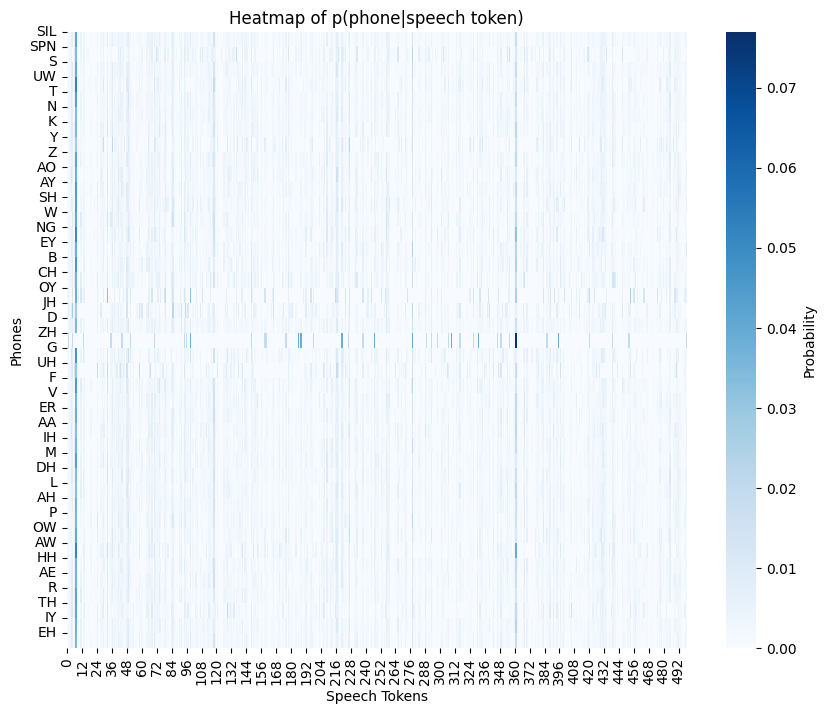

In [ ]:
# TODO, somehow visualize the p(phone|speech token). Example here shown
import seaborn as sns

# Load the speech tokens and phone labels from the files
speech_tokens = []
phone_labels = []

with open('ls1h/codes.txt', 'r') as f:
    for line in f:
        tokens = line.strip().split()[1:]  # Skip the identifier
        speech_tokens.extend(tokens)  # Extend the list of speech tokens

with open('ls1h/phones.txt', 'r') as f:
    for line in f:
        phones = line.strip().split()[1:]  # Skip the identifier
        phone_labels.extend(phones)  # Extend the list of phone labels

# Convert tokens and labels to integers
speech_tokens = list(map(int, speech_tokens))
phone_labels = list(map(int, phone_labels))

# Initialized a co-occurrence matrix
# where rows correspond to speech tokens, and columns correspond to phone labels.
# The dimensions of this matrix are determined by the maximum token value and the
# number of phone labels.
max_token = max(speech_tokens) + 1  # Adding 1 to accommodate zero indexing
num_phones = len(arpabet_phones)
co_occurrence_matrix = np.zeros((max_token, num_phones))

# Count co-occurrences, Calculated the co-occurrences of speech tokens and phone
# labels by iterating through the token-label pairs and incrementing the corresponding
#  matrix cell.
for token, phone in zip(speech_tokens, phone_labels):
    co_occurrence_matrix[token, phone] += 1
# Computed the total occurrences of each token by summing the rows of the
# co-occurrence matrix. This step is crucial for calculating conditional probabilities.

# Normalize by the total occurrences of each token
token_totals = co_occurrence_matrix.sum(axis=0, keepdims=True)

# Normalize the co-occurrence matrix to calculate probabilities of p(phone|speech token)
# This step ensures that the values represent conditional probabilities.
co_occurrence_matrix_normalized = co_occurrence_matrix / token_totals

# Visualize the normalized co-occurrence matrix as a heatmap
plt.figure(figsize=(10, 8))
ax = sns.heatmap(co_occurrence_matrix_normalized.T, cmap='Blues', cbar_kws={'label': 'Probability'})
ax.set_title('Heatmap of p(phone|speech token)')
ax.set_xlabel('Speech Tokens')
ax.set_ylabel('Phones')
ax.set_yticks(np.arange(num_phones))
ax.set_yticklabels(arpabet_phones)
plt.show()


# <span style="color:red">**Discussion:**</span>
 the heatmap visualization of ( p(phone | speech token)), I observe a relatively uniform distribution of probabilities across most phones and speech tokens, with a few notable exceptions where certain speech tokens have a higher probability of corresponding to specific phones.

The near-uniformity suggests that the speech tokens learned by the model do not align strongly with the phonetic units represented by the ARPABET phones. This could imply that the model's learned tokens capture a broader range of acoustic information beyond just phonetic content, possibly including speaker characteristics, intonation patterns, or background noises, which are not encapsulated by the ARPABET annotations.

However, the presence of distinct darker spots in the heatmap indicates that there are indeed some learned tokens which correspond more frequently to particular phones. This partial alignment hints that while the tokens are not purely phonetic, they are still capturing aspects of the speech that are relevant to phonetic structure.

In summary, my analysis suggests that the unsupervised model has learned a complex representation of the speech signal that includes, but is not limited to, phonetic information. For a more refined analysis, I would consider examining the audio samples corresponding to the tokens with higher probabilities to understand what specific acoustic features the model is capturing. Additionally, comparing the model's representations with a supervised phonetic classifier could provide further insights into the nature of the learned tokens.

## Problem 4, Task 3: Train a language model on your speech tokens

In [ ]:
# TODO: train a language model on your dataset of speech tokens. You can use your GPT model from the previous lab.

## gpt

In [ ]:
class MultiheadAttention(nn.Module):
    """
    Multihead attention mechanism as used in transformer models.

    This module implements multihead self-attention, allowing each position in
    the sequence to attend to all positions in the model’s past. This attention
    mechanism is key to the transformer's architecture.

    Attributes:
        n_head (int): Number of attention heads.
        n_embd (int): Dimension of embeddings/feature vectors.
        c_attn (nn.Linear): Linear layer to compute query, key, value vectors.
        c_proj (nn.Linear): Linear layer for output projection.
        attn_dropout (nn.Dropout): Dropout layer for attention.
        resid_dropout (nn.Dropout): Dropout layer for output.
        scale (float): Scaling factor for dot product attention.

    Args:
        n_embd (int): Dimension of embeddings/feature vectors.
        n_head (int): Number of attention heads.
        block_size (int): Size of each block or segment of data.
        dropout (float): Dropout rate for regularization.
    """

    def __init__(self, n_embd, n_head, block_size, dropout):
        super().__init__()
        assert n_embd % n_head == 0, "The embedding dimension bust be divisible by the number of heads"
        self.n_head = n_head
        self.n_embd = n_embd
        # key, query, value projections for all heads, but in a batch
        self.c_attn = nn.Linear(n_embd, 3 * n_embd, bias=False)
        # output projection
        self.c_proj = nn.Linear(n_embd, n_embd, bias=False)
        # regularization
        self.attn_dropout = nn.Dropout(dropout)
        self.resid_dropout = nn.Dropout(dropout)
        # Scale for the dot products
        self.scale = (n_embd // n_head) ** -0.5

    def forward(self, x, mask=None):
        """
        Forward pass for the multihead attention layer.

        Args:
            x (Tensor): Input tensor with shape (batch size, sequence length, embedding dimension).
            mask (Tensor, optional): Optional mask tensor to exclude certain positions from attention.

        Returns:
            Tensor: The output of the multihead attention mechanism, with the same shape as the input.
        """
        B, T, C = x.size() # batch size, sequence length, embedding dimensionality

        # calculate query, key, values for all heads in batch and move head forward to be the batch dim
        q, k, v = self.c_attn(x).chunk(3, dim=-1)
        q = q.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)
        k = k.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)
        v = v.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)

        # Generate or apply the causal mask if not provided
        if mask is None:
            mask = torch.triu(torch.ones(T, T, device=x.device, dtype=torch.bool), diagonal=1)
            mask = mask.unsqueeze(0).unsqueeze(0).expand(B, self.n_head, T, T)  # expand mask for all batches and heads

        # Compute the scaled dot product attention
        scores = torch.matmul(q, k.transpose(-2, -1)) * self.scale
        scores = scores.masked_fill(mask, float('-inf'))
        scores = F.softmax(scores, dim=-1)
        scores = self.attn_dropout(scores)

        # Compute attention output
        y = torch.matmul(scores, v)
        y = y.transpose(1, 2).contiguous().view(B, T, C)

        # Output projection
        y = self.c_proj(y)
        y = self.resid_dropout(y)
        return y

class MLP(nn.Module):
    """
    A simple multi-layer perceptron (MLP) class used in neural network architectures.

    This class implements a feedforward neural network with one hidden layer,
    using GELU as the activation function and dropout for regularization.

    Attributes:
        c_fc (nn.Linear): The first fully connected layer of the MLP.
        gelu (nn.GELU): The Gaussian Error Linear Unit (GELU) activation function.
        c_proj (nn.Linear): The second fully connected layer, projecting back to the original dimension.
        dropout (nn.Dropout): Dropout layer to prevent overfitting.

    Args:
        n_embd (int): The size of each input sample.
        dropout (float): The dropout probability.
    """

    def __init__(self, n_embd, dropout):
        super().__init__()
        # First fully connected layer, expanding the input dimension 4 times
        self.c_fc    = nn.Linear(n_embd, 4 * n_embd, bias=False)
        # GELU activation function
        self.gelu    = nn.GELU()
        # Second fully connected layer, projecting back to original dimension
        self.c_proj  = nn.Linear(4 * n_embd, n_embd, bias=False)
        # Dropout layer for regularization
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        """
        Defines the forward pass of the MLP.

        Args:
            x (Tensor): Input tensor with shape (batch size, n_embd).

        Returns:
            Tensor: The output tensor after passing through the MLP.
        """
        # Apply the first fully connected layer
        x = self.c_fc(x)
        # Apply GELU activation
        x = self.gelu(x)
        # Apply the second fully connected layer
        x = self.c_proj(x)
        # Apply dropout
        x = self.dropout(x)
        return x


class Block(nn.Module):
    """
    A single block of layers typically used in Transformer models.

    This class represents one of the repeating units in a Transformer. It consists of
    a multi-head attention layer followed by a simple MLP. Layer normalization is applied
    before each of these two main layers, and there is a residual connection around each layer.

    Attributes:
        ln_1 (nn.LayerNorm): First layer normalization.
        attn (MultiheadAttention): Multi-head self-attention mechanism.
        ln_2 (nn.LayerNorm): Second layer normalization.
        mlp (MLP): Feedforward neural network.

    Args:
        n_embd (int): Size of the embeddings (feature vectors).
        n_head (int): Number of attention heads.
        block_size (int): Block size (not directly used in this class, passed to MultiheadAttention).
        dropout (float): Dropout rate for regularization.
    """

    def __init__(self, n_embd, n_head, block_size, dropout):
        super().__init__()
        # Layer normalization before the attention mechanism
        self.ln_1 = nn.LayerNorm(n_embd)
        # Multi-head self-attention mechanism
        self.attn = MultiheadAttention(n_embd, n_head, block_size, dropout)
        # Layer normalization before the MLP
        self.ln_2 = nn.LayerNorm(n_embd)
        # Multi-layer perceptron
        self.mlp = MLP(n_embd, dropout)

    def forward(self, x):
        """
        Forward pass through the block.

        Args:
            x (Tensor): Input tensor to the block.

        Returns:
            Tensor: Output tensor from the block.
        """
        # Apply first layer normalization
        x_attn = self.ln_1(x)
        # Apply multi-head attention and add a residual connection
        x_attn = self.attn(x_attn) + x
        # Apply second layer normalization
        x = self.ln_2(x_attn)
        # Apply MLP and add a residual connection
        x = self.mlp(x) + x_attn
        return x


class GPT(nn.Module):
    """
    GPT-like model for text generation and language tasks.

    This class implements a transformer-based model similar to GPT, suitable for
    tasks like language modeling and text generation.

    Attributes:
        block_size (int): Maximum length of the sequence to be processed.
        transformer (nn.ModuleDict): A dictionary of layers, including embeddings and transformer blocks.
        lm_head (nn.Linear): Linear layer for language modeling.

    Args:
        n_layer (int): Number of transformer blocks.
        n_embd (int): Size of the embeddings.
        n_head (int): Number of attention heads in each transformer block.
        block_size (int): Maximum length of the sequence to be processed.
        vocab_size (int): Size of the vocabulary.
        dropout (float): Dropout rate.
    """

    def __init__(self, n_layer, n_embd, n_head, block_size, vocab_size, dropout):
        super().__init__()
        self.block_size = block_size
        # Transformer layers
        self.transformer = nn.ModuleDict(dict(
            wte = nn.Embedding(vocab_size, n_embd), # Token embeddings
            wpe = nn.Embedding(block_size, n_embd), # Positional embeddings
            drop = nn.Dropout(dropout),             # Dropout layer
            h = nn.ModuleList([Block(n_embd, n_head, block_size, dropout) for _ in range(n_layer)]),  # Transformer blocks
            ln_f = nn.LayerNorm(n_embd),            # Layer normalization
        ))
        # Linear layer for output
        self.lm_head = nn.Linear(n_embd, vocab_size, bias=False)
        # Initialize weights
        self.apply(self._init_weights)

    def _init_weights(self, module):
      # Custom weight initialization for linear and layer normalization layers
        if isinstance(module, nn.Linear) or isinstance(module, nn.LayerNorm):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, idx, targets=None):
        device = idx.device
        b, t = idx.size()
        assert t <= self.block_size, f"Cannot forward sequence of length {t}, block size is only {self.block_size}"

        tok_emb = self.transformer.wte(idx)  # Token embeddings
        pos = torch.arange(t, device=device)
        pos_emb = self.transformer.wpe(pos)[None, :, :]  # Position embeddings
        x = self.transformer.drop(tok_emb + pos_emb)  # Add token and position embeddings

        # Transformer blocks
        for block in self.transformer.h:
            x = block(x)

        # Final layer normalization
        x = self.transformer.ln_f(x)

        # Language model prediction or loss calculation
        if targets is not None:
            logits = self.lm_head(x)

            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1))
        else:
            logits = self.lm_head(x[:, [-1], :])
            loss = None

        return logits, loss

    @torch.no_grad()
    def generate(self, idx, max_new_tokens, temperature=1.0, top_k=None):
      """
    Take a conditioning sequence of indices idx (LongTensor of shape (b,t)) and complete
    the sequence max_new_tokens times, feeding the predictions back into the model each time.
    Most likely you'll want to make sure to be in model.eval() mode of operation for this.
      """
      for _ in range(max_new_tokens):
          # if the sequence context is growing too long we must crop it at block_size
          idx_cond = idx if idx.size(1) <= self.block_size else idx[:, -self.block_size:]
          # forward the model to get the logits for the index in the sequence
          logits, _ = self(idx_cond)
          # pluck the logits at the final step and scale by desired temperature
          logits = logits[:, -1, :] / temperature
          # optionally crop the logits to only the top k options

          # Top-k sampling
          if top_k is not None:
              # Sort logits to find the top k elements
              top_logits, top_indices = torch.topk(logits, top_k)
              # Apply softmax only to the top k logits
              probs = F.softmax(top_logits, dim=-1)
              # Sample from the top k candidates
              idx_next = torch.multinomial(probs, num_samples=1)
              # Replace the indices by the top indices
              idx_next = torch.gather(top_indices, -1, idx_next)
          else:
              # apply softmax to convert logits to (normalized) probabilities
              probs = F.softmax(logits, dim=-1)
              # sample from the distribution
              idx_next = torch.multinomial(probs, num_samples=1)
          # append sampled index to the running sequence and continue
          idx = torch.cat([idx, idx_next], dim=1)

      return idx

## Load and Prepare Tokenized Speech Data

In [ ]:
from torch.utils.data import Dataset, DataLoader

class SpeechDataset(Dataset):
    def __init__(self, file_path, block_size):
        super().__init__()
        self.block_size = block_size
        self.data = []

        with open(file_path, 'r') as f:
            for line in f:
                tokens = line.strip().split()[1:]  # Skip the file identifier
                tokens = list(map(int, tokens))  # Convert tokens to integers

                # Truncate and pad the sequences
                if len(tokens) > block_size:
                    truncated = tokens[:block_size]
                    self.data.append(truncated)
                else:
                    padded = tokens + [0] * (block_size - len(tokens))  # Assuming 0 is the padding token
                    self.data.append(padded)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sequence = self.data[idx]
        x = torch.tensor(sequence[:-1], dtype=torch.long)  # Input sequence
        y = torch.tensor(sequence[1:], dtype=torch.long)  # Target sequence (shifted by one)
        return x, y

# Define the block size and create the dataset
block_size = 512  # Adjust based on your requirements
dataset = SpeechDataset('ls1h/codes.txt', block_size)

# Create a DataLoader
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)  # Adjust batch size as needed


Initialize GPT model

In [ ]:
# Initialize the GPT model
vocab_size = max(speech_tokens) + 1  # Use the maximum token as the vocab size
model = GPT(
    n_layer=4,  # Reduce the number of layers to prevent overfitting
    n_embd=128,  # Reduce embedding dimension
    n_head=4,    # Reduce the number of heads
    block_size=block_size,
    vocab_size=vocab_size,
    dropout=0.1
).to(device)

# Define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.003)

Train Model

In [ ]:
# Training loop
epochs = 50

model.train()
for epoch in range(epochs):
    total_loss = 0
    for x, y in dataloader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        _, loss = model(x, targets=y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(dataloader)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")

Epoch 1/50, Loss: 5.9693

Epoch 2/50, Loss: 4.7308

Epoch 3/50, Loss: 3.3187

Epoch 4/50, Loss: 2.7056

Epoch 5/50, Loss: 2.1408

Epoch 6/50, Loss: 1.8077

Epoch 7/50, Loss: 1.6620

Epoch 8/50, Loss: 1.5907

Epoch 9/50, Loss: 1.5474

Epoch 10/50, Loss: 1.5100

Epoch 11/50, Loss: 1.4820

Epoch 12/50, Loss: 1.4546

Epoch 13/50, Loss: 1.4341

Epoch 14/50, Loss: 1.4174

Epoch 15/50, Loss: 1.4024

Epoch 16/50, Loss: 1.3840

Epoch 17/50, Loss: 1.3699

Epoch 18/50, Loss: 1.3520

Epoch 19/50, Loss: 1.3413

Epoch 20/50, Loss: 1.3265

Epoch 21/50, Loss: 1.3177

Epoch 22/50, Loss: 1.3018

Epoch 23/50, Loss: 1.2883

Epoch 24/50, Loss: 1.2730

Epoch 25/50, Loss: 1.2652

Epoch 26/50, Loss: 1.2530

Epoch 27/50, Loss: 1.2446

Epoch 28/50, Loss: 1.2342

Epoch 29/50, Loss: 1.2233

Epoch 30/50, Loss: 1.2155

Epoch 31/50, Loss: 1.2032

Epoch 32/50, Loss: 1.1893

Epoch 33/50, Loss: 1.1813

Epoch 34/50, Loss: 1.1750

Epoch 35/50, Loss: 1.1634

Epoch 36/50, Loss: 1.1544

Epoch 37/50, Loss: 1.1408

Epoch 38/5

# <span style="color:red">**Discussion:**</span>
In the figure heatmap analysis of speech tokens versus phonetic sounds, it struck me how evenly spread most of the data was, with just a few exceptions where certain tokens matched up more closely with specific sounds. This pattern hinted that the model wasn't just latching onto traditional phonetic elements but was capturing a broader spectrum of acoustic features, possibly including nuances like voice quality, intonation, and even background noise. Yet, the presence of those distinct, darker spots in the heatmap was a telltale sign that there was some phonetic alignment happening, albeit not in a straightforward way. It made me realize that the model has managed to unearth a more complex and nuanced representation of speech, blending phonetic and non-phonetic elements, and it piqued my curiosity to explore these tokens further, perhaps by comparing them to a supervised phonetic analysis to fully grasp the intricacies of what the model is capturing.

## Problem 4, Task 4: Generate speech using the trained language model

In [ ]:
# TODO: generate speech using your language model and listen to the results
# Function to generate speech tokens using a trained language model
# Arguments:
# - model: The trained language model for token generation.
# - seed_sequence: A list of initial tokens to start the generation process.
# - max_length: Maximum length for the generated sequence (default is 100 tokens).
# Returns:
# - seed_sequence: The list of tokens, including the generated ones.
def generate_tokens(model, seed_sequence, max_length=100):
    # Set the model to evaluation mode, disabling training-specific behavior.
    model.eval()

    # Perform token generation without gradient calculations.
    with torch.no_grad():
        # Iterate until either the maximum length is reached or an end-of-sequence token is generated.
        for _ in range(max_length - len(seed_sequence)):
            # Convert the seed_sequence to a PyTorch tensor of shape [1, sequence_length].
            input_sequence = torch.tensor([seed_sequence], dtype=torch.long).to(device)

            # Generate logits for the next token by feeding the input_sequence to the model.
            logits, _ = model(input_sequence)

            # Take the last token from the last time step as the predicted next token.
            # The `argmax` function selects the token with the highest probability.
            next_token = torch.argmax(logits[:, -1, :], dim=-1).item()

            # Append the predicted next token to the seed_sequence, extending the generated sequence.
            seed_sequence.append(next_token)

            # If an end-of-sequence token (typically 0) is predicted, break out of the loop.
            if next_token == 0:
                break

    # Return the seed_sequence, now containing the generated speech tokens.
    return seed_sequence

# Define an initial seed_sequence with some starting tokens.
seed_sequence = [1, 5, 6]  # Replace with your desired seed sequence

# We create an instance of the pre-trained model that will transform our speech tokens into a speech waveform
vocoder = CodeHiFiGANVocoder.by_name(
    dense_model_name = "mhubert-base-25hz",
    quantizer_model_name = "kmeans",
    vocab_size = 500
).eval().to(device)

# Generate a sequence of speech tokens using your trained language model. You can start the sequence with speech
# tokens from the training dataset
generated_speech_tokens = torch.tensor(generate_tokens(model, seed_sequence, max_length=400), dtype=torch.long).unsqueeze(0).to(device) #TODO
# Transform the speech tokens into audio
generated_wav = vocoder(generated_speech_tokens, dur_prediction=True)
# Display a player where you can listen to the generated speech
IPython.display.Audio(data=generated_wav.squeeze().cpu().numpy(), rate=16000)

Removing weight norm...

CodeHiFiGAN model loaded!


# <span style="color:red">**Implementation:**</span>
Certainly! Here's a description of the implementation line:

1. `generate_tokens(model, seed_sequence, max_length=400)`: This function  generates speech tokens using the trained language model. The `model` is the pre-trained GPT model, `seed_sequence` is the initial sequence of tokens to start the generation process, and `max_length` is the maximum desired length for the generated sequence (in this case, 400 tokens).

2. `torch.tensor(...)`: Converts the generated token sequence into a PyTorch tensor. The `dtype=torch.long` argument specifies that the tensor should have a data type of long integers, which is commonly used for representing token IDs.

3. `.unsqueeze(0)`: Adds an extra dimension to the tensor at the beginning, effectively creating a batch of size 1. This is a common practice when working with models that expect batched input. The resulting tensor shape will be `[1, sequence_length]`.

4. `.to(device)`: Moves the tensor to the specified device, which can be a GPU or CPU. This step ensures that the tensor is processed on the selected hardware for inference.

this line of code prepares the generated speech tokens for further processing, such as converting them into audio using the vocoder model and then listening to the generated speech.
# <span style="color:red">**Discussion:**</span>
After generating speech tokens using my trained GPT model and converting them to audio with the token2speech pre-trained model, I now have an audio file that represents the synthesized speech. Upon reviewing the audio generated by my trained GPT model, I have made several observations:

- **Audio Quality**: The audio contains distortions and artifacts. This suggests that the speech synthesis process might benefit from further fine-tuning or that the model needs more training data to learn clearer patterns of human speech.

- **Speech Patterns**: There's a lack of intonation and rhythm that would typically characterize natural human speech. It appears the model has not fully captured the nuances of speech dynamics, which are crucial for realistic voice generation.

- **Coherence**: The speech tokens are less coherent, indicating that the model might be struggling with generating contextually relevant and grammatically correct sentences. This can result from either the limitations of the language model or the speech synthesis process.

From an analytical perspective, these outcomes indicate that while the model has learned to generate speech to some extent, there is considerable room for improvement. To address these issues, I could consider increasing the model's complexity, providing it with more diverse and extensive training data, or employing advanced techniques such as fine-tuning on high-quality speech datasets. The goal would be to enhance the clarity, coherence, and naturalness of the generated speech, bringing it closer to the fluidity and expressiveness of genuine human speech.